# Training a machine learning model with and without Adjusted Relative Amplitudes

I aim to document and compare experimental results training a machine learning model on the data with and without adjusted relative amplitudes (ARA). My hypothesis is that ARA are a reliable and relevant representation of the relationship between a single ICF pulse and a group of test pulses. Should this hypothesis be correct, the inclusion of ARA in the model should increase its accuracy to some degree.

The chosen algorithm was an ensemble of *decision trees*. Such decision was based on the preference of white-box models and the relatively small training set. *AdaBoost* was used to further improve the ensembles's accuracy. All code was written in Python using *pandas*, *numpy* and *scikit-learn*. The results are as follow.

# Model 1: Without ARA

Let us first import the necessary packages and display how our database looks like.

In [3]:
import pandas as pd
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np

In [114]:
data = pd.read_csv('data.csv')
data = data.drop(['Group', 'Compare', 'Session', 'Subject', 'SessionType', 'Unnamed: 0', 'Sample'], axis=1)
data['Type'] = data['Type'].str.extract('(\d+)').astype(int)

data['Type'] = pd.to_numeric(data['Type'])
data['ISI'] = pd.to_numeric(data['ISI'])
data

,Type,Label,ISI,EMGPeakToPeak,ARA,ARAGaussian,ARA_Alpha5,ARA_Alpha3,ARA_Alpha10
0,120,HC SWD,10,209.7900,0.85757,0.796,0.928,0.909,0.944
1,120,HC SWD,0,209.7900,0.85757,0.796,0.928,0.909,0.944
2,120,HC SWD,8,199.5286,0.81563,0.757,0.883,0.865,0.897
3,120,HC SWD,0,199.5286,0.81563,0.757,0.883,0.865,0.897
4,120,HC SWD,-1,258.8171,1.05799,0.982,1.145,1.121,1.164
...,...,...,...,...,...,...,...,...,...
6187,72,HC BL,-1,94.6336,1.08215,1.081,1.096,1.098,1.087
6188,72,HC BL,15,762.7693,8.72238,8.715,8.832,8.853,8.758
6189,72,HC BL,5,85.5123,0.97785,0.977,0.990,0.993,0.982
6190,72,HC BL,20,240.5745,2.75101,2.749,2.786,2.792,2.762


Our model will try to predict to what label each pulse belongs given the rest of the information; namely, for each pulse, the corresponding EMG amplitude, ISI and ICF Session Type (was it a session of $72$ or $120$ pulses?). 

In [96]:
X = data.drop(['Label'], axis=1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

bag_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=20, algorithm='SAMME.R', learning_rate=0.1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.39709443099273606

Our models accuracy is of $40\%$. This is considerably better than guessing randomly among the four labels. However, to better understand the performance of our model we can use a confusion matrix.

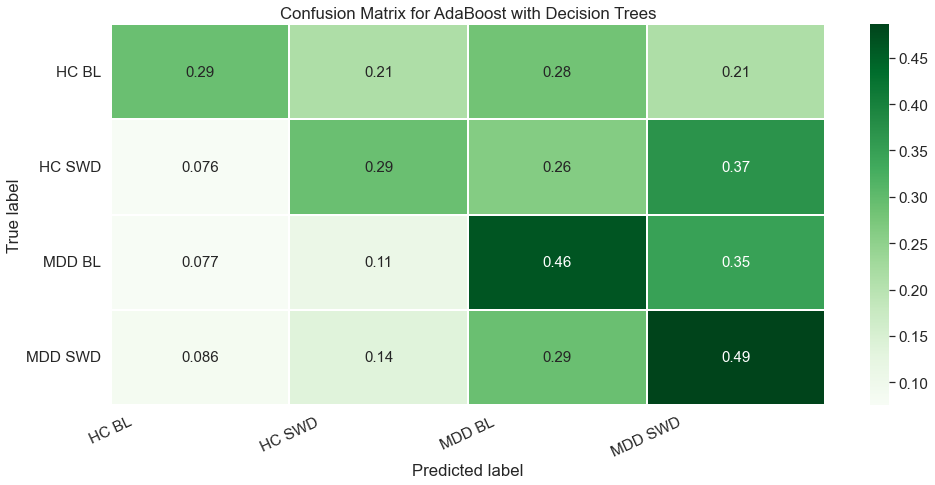

In [97]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['HC BL', 'HC SWD', 'MDD BL', 
               'MDD SWD']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for AdaBoost with Decision Trees')
plt.show()

The model is not doing very well. It seems like its doing better predicting MDD subjects. However, it is very frequently mislabeling HC subjects as MDD as well. If you persist on guessing people is MDD, it is only natural you should succeed those times you are actually dealing with an MDD —with no merit! The question is if including ARA will increase accuracy or not; i.e., if ARA are a meaningful descriptive measure conveying differential information for all categories. 

# Model 2: With ARA

Let us include the ARA of each ICF pulse in our data set and retrain the model including this information.

In [111]:
data = pd.read_csv('data.csv')
data = data.drop(['Group', 'Session', 'ARAGaussian', 'Compare', 'ARA_Alpha3', 'ARA_Alpha5', 'ARA_Alpha10', 'Subject', 'SessionType', 'Unnamed: 0', 'Sample'], axis=1)
data['Type'] = data['Type'].str.extract('(\d+)').astype(int)
data['Type'] = pd.to_numeric(data['Type'])

data

,Type,Label,ISI,EMGPeakToPeak,ARA
0,120,HC SWD,10,209.7900,0.85757
1,120,HC SWD,0,209.7900,0.85757
2,120,HC SWD,8,199.5286,0.81563
3,120,HC SWD,0,199.5286,0.81563
4,120,HC SWD,-1,258.8171,1.05799
...,...,...,...,...,...
6187,72,HC BL,-1,94.6336,1.08215
6188,72,HC BL,15,762.7693,8.72238
6189,72,HC BL,5,85.5123,0.97785
6190,72,HC BL,20,240.5745,2.75101


In [112]:
X = data.drop(['Label'], axis=1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

bag_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=20, algorithm='SAMME.R', learning_rate=0.1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc


0.7861178369652946

The accuracy of the model has raised to $78\%$, which is nearly twice as much as the previous accuracy. But to get a better notion we should draw another confusion matrix.

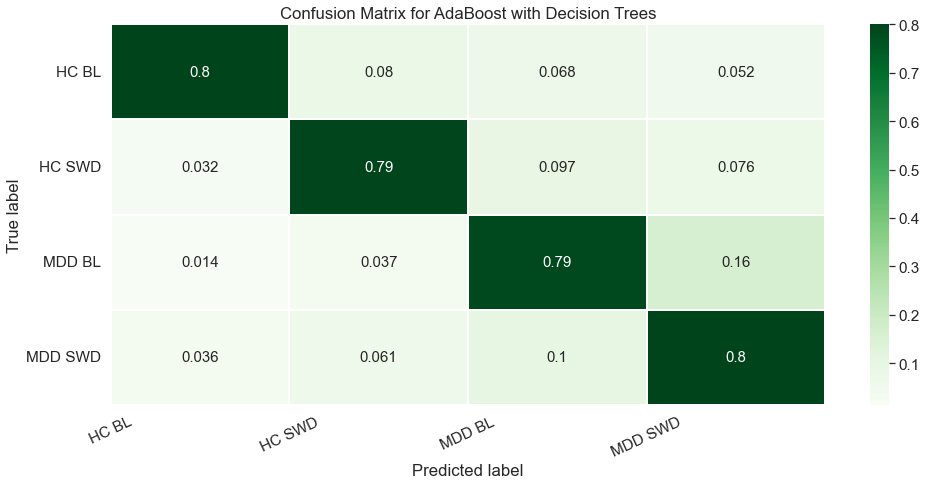

In [104]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['HC BL', 'HC SWD', 'MDD BL', 
               'MDD SWD']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for AdaBoost with Decision Trees')
plt.show()

SyntaxError: invalid syntax (1589173412.py, line 8)

This looks far better than the confusion matrix of the first, ARA-lacking model. Not only it very accurately predicts, from a pulses' ISI, EMG and ARA, whether it belongs to one or another subject category — but it also makes reasonable mistakes! (To see this, simply inspect what is the most frequent incorrect prediction for each true label.)

# Conclusion

The inclusion of adjusted relative amplitudes greatly enhances the performance of our boosted ensemble of decision trees. This implies the adjusted relative amplitudes of a pulse contains information relevant to the subject's condition, where by condition I mean both its pertenance to the HC or MDD group as well as what session it underwent. 

The results thus support the idea that adjusted relative amplitudes are a relevant, not misleading measure of the relative amplitud of ICF pulses with respect to test pulses. 

In [133]:
data = pd.read_csv('data.csv')
data = data.drop(['Group', 'Compare','Session', 'Subject', 'SessionType', 'Unnamed: 0', 'Sample'], axis=1)
data['Type'] = data['Type'].str.extract('(\d+)').astype(int)

data

,Type,Label,ISI,EMGPeakToPeak,ARA,ARAGaussian,ARA_Alpha5,ARA_Alpha3,ARA_Alpha10
0,120,HC SWD,10,209.7900,0.85757,0.796,0.928,0.909,0.944
1,120,HC SWD,0,209.7900,0.85757,0.796,0.928,0.909,0.944
2,120,HC SWD,8,199.5286,0.81563,0.757,0.883,0.865,0.897
3,120,HC SWD,0,199.5286,0.81563,0.757,0.883,0.865,0.897
4,120,HC SWD,-1,258.8171,1.05799,0.982,1.145,1.121,1.164
...,...,...,...,...,...,...,...,...,...
6187,72,HC BL,-1,94.6336,1.08215,1.081,1.096,1.098,1.087
6188,72,HC BL,15,762.7693,8.72238,8.715,8.832,8.853,8.758
6189,72,HC BL,5,85.5123,0.97785,0.977,0.990,0.993,0.982
6190,72,HC BL,20,240.5745,2.75101,2.749,2.786,2.792,2.762


In [134]:
X = data.drop(['Label'], axis=1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

bag_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=20, algorithm='SAMME.R', learning_rate=0.1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc


0.8426150121065376

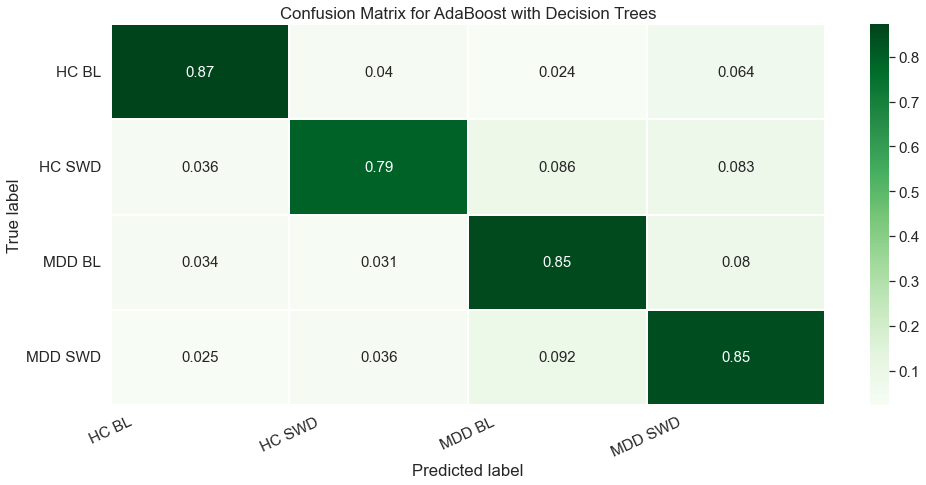

In [135]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['HC BL', 'HC SWD', 'MDD BL', 
               'MDD SWD']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for AdaBoost with Decision Trees')
plt.show()

In [130]:
data = pd.read_csv('data.csv')
data = data.drop(['Group', 'ARA_Alpha5', 'ARA_Alpha3', 'ARA', 'ARA_Alpha10', 'Compare', 'Session', 'Subject', 'SessionType', 'Unnamed: 0', 'Sample'], axis=1)
data['Type'] = data['Type'].str.extract('(\d+)').astype(int)

data

,Type,Label,ISI,EMGPeakToPeak,ARAGaussian
0,120,HC SWD,10,209.7900,0.796
1,120,HC SWD,0,209.7900,0.796
2,120,HC SWD,8,199.5286,0.757
3,120,HC SWD,0,199.5286,0.757
4,120,HC SWD,-1,258.8171,0.982
...,...,...,...,...,...
6187,72,HC BL,-1,94.6336,1.081
6188,72,HC BL,15,762.7693,8.715
6189,72,HC BL,5,85.5123,0.977
6190,72,HC BL,20,240.5745,2.749


In [131]:
X = data.drop(['Label'], axis=1)
y = data['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

bag_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=8), n_estimators=20, algorithm='SAMME.R', learning_rate=0.1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.7732041969330105

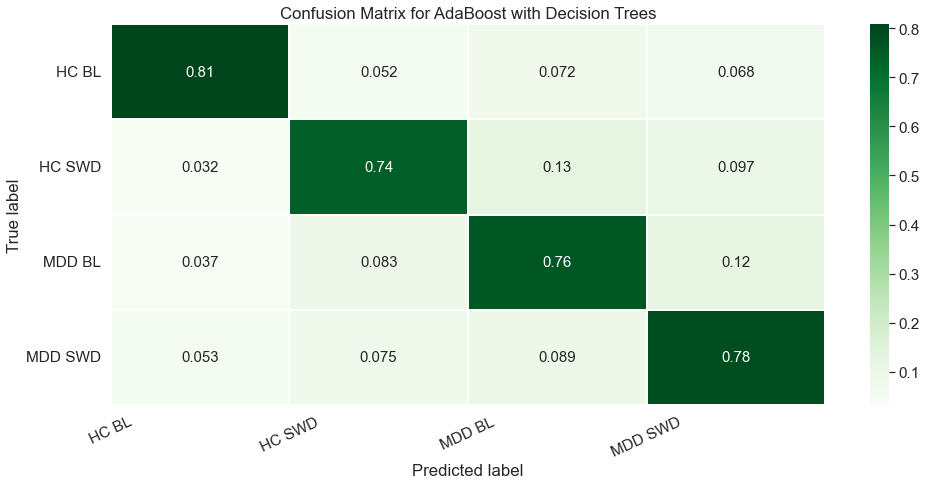

In [132]:
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':15},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['HC BL', 'HC SWD', 'MDD BL', 
               'MDD SWD']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for AdaBoost with Decision Trees')
plt.show()

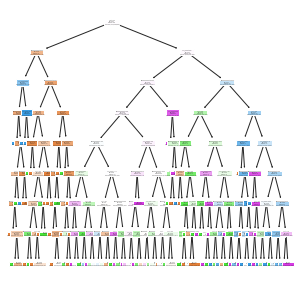